In [1]:
from pathlib import Path

import numpy as np
import numpy.linalg as alg
from matplotlib import pyplot as plt
from scipy.optimize import root

from fem_linear import (calculate_element_properties, local_stiffness_matrix, assign_Fex, assign_Uex)
from utils import get_pile_data, refine_mesh
from utils.visualization import init_plot

In [2]:
input_dir = Path('./data/input')

xyz, elem, section, properties = get_pile_data(input_dir, "P3")
xyz, elem, section, map_dof = refine_mesh(xyz, elem, section, n=5)

In [29]:
Fex = [(map_dof(2), 1, -100.0e6)]

Uex = [(map_dof(11), 1, 0.0),
       (map_dof(11), 2, 0.0)]

In [4]:
elem_in_soil = elem[map_dof(4)-1:]
H = 17.0
sa = -0.01*H
sp = -10.0*sa
theta = 30.0
gamma = 19.0

In [39]:
# Grados de libertad por nodo
n_dof = 2

# Matriz de propiedades de los elementos
element_properties = calculate_element_properties(xyz, elem, section, properties)
E = element_properties[:, 0]
Iz = element_properties[:, 1]
L = element_properties[:, 2]

# --------------------------------------------

# Grados de libertad totales (GDL)
dof_t = n_dof * xyz.shape[0]

# Ensamblaje de la matriz de rigidez
Px = 500.0
K = np.zeros((dof_t, dof_t))
offset = np.arange(n_dof, 0, -1, dtype=int)
for i in range(elem.shape[0]):
    dof_i = elem[i, 0]*n_dof - offset
    dof_j = elem[i, 1]*n_dof - offset
    dof_e = np.append(dof_i, dof_j)

    Ke = local_stiffness_matrix(E[i], Iz[i], L[i], Px)
    K[np.ix_(dof_e, dof_e)] += Ke

# Inicia el vector de desplazamientos
u = np.zeros((dof_t))

# Ensamblaje del vector de fuerzas externas
f0 = np.zeros((dof_t))
assign_Fex(f0, Fex, n_dof)

# display(f0)

# K_ = K.copy()

# f = f0.copy()
# assign_Uex(f, K_, Uex, n_dof)
# u = alg.solve(K_, f)

# def R(u, L, sa, sp, gamma, theta, elem_in_soil, n_dof):
#     return np.dot(K, u) - f1 - soil_reaction(u, L, sa, sp, gamma, theta, elem_in_soil, n_dof)


# sol = root(R, x0=u, args=(L, sa, sp, gamma, theta, elem_in_soil, n_dof), method='krylov', options={'xtol': 1e-6, 'maxiter': 200})

In [6]:
init_plot(scl_a4=1, aspect_ratio=[3, 4], page_lnewdth_cm=10, fnt="arial")

output_dir = Path('./data/output')

fig, ax = plt.subplots(1, 1)

ax.plot(u[::2]*1000, xyz)

ax.set_xlabel("Displacement [mm]")
ax.set_ylabel("Depth [m]")
ax.set_title("Displacement along the pile")

fig.tight_layout()
fig.savefig(output_dir/"displacement.png")
plt.close()

In [7]:
print(np.sum(f1.reshape(-1, 3)[:, 0]))
f2 = soil_reaction(sol.x, L, sa, sp, gamma, theta, elem_in_soil, n_dof)
print(np.sum(f2.reshape(-1, 3)[:, 0]))

NameError: name 'f1' is not defined

In [14]:
print(u.reshape(-1, 2))

[[-1.89488847e-05 -1.24654702e-06]
 [-1.89164745e-05 -1.24654702e-06]
 [-1.88840643e-05 -1.24654702e-06]
 ...
 [-1.86152732e-11 -2.32657181e-09]
 [-4.65449297e-12 -1.16353891e-09]
 [ 0.00000000e+00  0.00000000e+00]]


In [ ]:
K_ = K.copy()

assign_Uex(f, K_, Uex, n_dof)
u = alg.solve(K_, f)
f = np.dot(K, u)


In [109]:
sr = soil_reaction(u, L, sa, sp, gamma, theta, elem_in_soil, n_dof)
sr_ = sr.reshape(-1, 3)
np.sum(sr_[:, 0])

-5318.709111763434

In [55]:
def J(K, f, u, L, sa, sp, gamma, theta, elem_in_soil, n_dof, dof_t, eps):
    dfdu = np.zeros((dof_t, dof_t))
    _u = u.copy()
    for i in range(dof_t):
        _u[i] += eps
        _f = soil_reaction(_u, L, sa, sp, gamma, theta, elem_in_soil, n_dof)
        dfdu[:, i] = (_f - f) / eps
        _u[i] -= eps

    return K-dfdu

Jac = J(K, f, u, L, sa, sp, gamma, theta, elem_in_soil, n_dof, dof_t, 1e-6)


In [34]:
from utils.earth_pressure import Ks
from scipy.integrate import quad_vec

from typing import Callable


def w(xi, Le):
    w_vec = np.array([[1 - 3*xi**2 + 2*xi**3],
                      [Le*(xi-2*xi**2 + xi**3)],
                      [3*xi**2 - 2*xi**3],
                      [Le*(-xi**2 + xi**3)]])
    return w_vec


def interpolate_u(xi, Le, ue):
    return np.dot(w(xi, Le).T, ue).reshape(-1)


def p_ls(xi, Le, z0, gamma, sa, sp, theta, ue):
    s = interpolate_u(xi, Le, ue)
    return - Ks(-s, sa, sp, theta) * gamma * (Le*xi + z0)


def p_rs(xi, Le, z0, gamma, sa, sp, theta, ue):
    s = interpolate_u(xi, Le, ue)
    return Ks(s, sa, sp, theta) * gamma * (Le*xi + z0)


def soil_reaction(u, L, sa, sp, gamma, theta, p: Callable, elem, n_dof) -> None:
    # elem = [elem1, elem2]
    def g(xi, Le, z0, gamma, sa, sp, theta, ue):
        return Le * w(xi, Le) * p(xi, Le, z0, gamma, sa, sp, theta, ue)
    
    
    n_elem = elem.shape[0]

    z = 0.0
    f = np.zeros((dof_t))
    offset = np.arange(n_dof, 0, -1, dtype=int)
    for elem_id in range(n_elem):
        dof_n1 = elem[elem_id, 0]*n_dof - offset
        dof_n2 = elem[elem_id, 1]*n_dof - offset
        dof_n12 = np.hstack((dof_n1, dof_n2))

        Le = L[elem_id]
        ue = u[np.ix_(dof_n12)]
        
        res, _ = quad_vec(g, 0, 1, args=(Le, z, gamma, sa, sp, theta, ue), epsrel=1e-6, limit=1000)
        f[np.ix_(dof_n12)] += res.reshape(-1)

        z += Le
    
    return f

In [40]:
elem_in_soil = elem[map_dof(4)-1:]
H = 17.0
sa = -0.01*H
sp = -10.0*sa
theta = 30.0
gamma = 19.0

f_ls = soil_reaction(u, L, sa, sp, gamma, theta, p_ls, elem_in_soil, n_dof)
f_rs = soil_reaction(u, L, sa, sp, gamma, theta, p_rs, elem_in_soil, n_dof)
print(np.column_stack((f_ls, f_rs)))

[[ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0

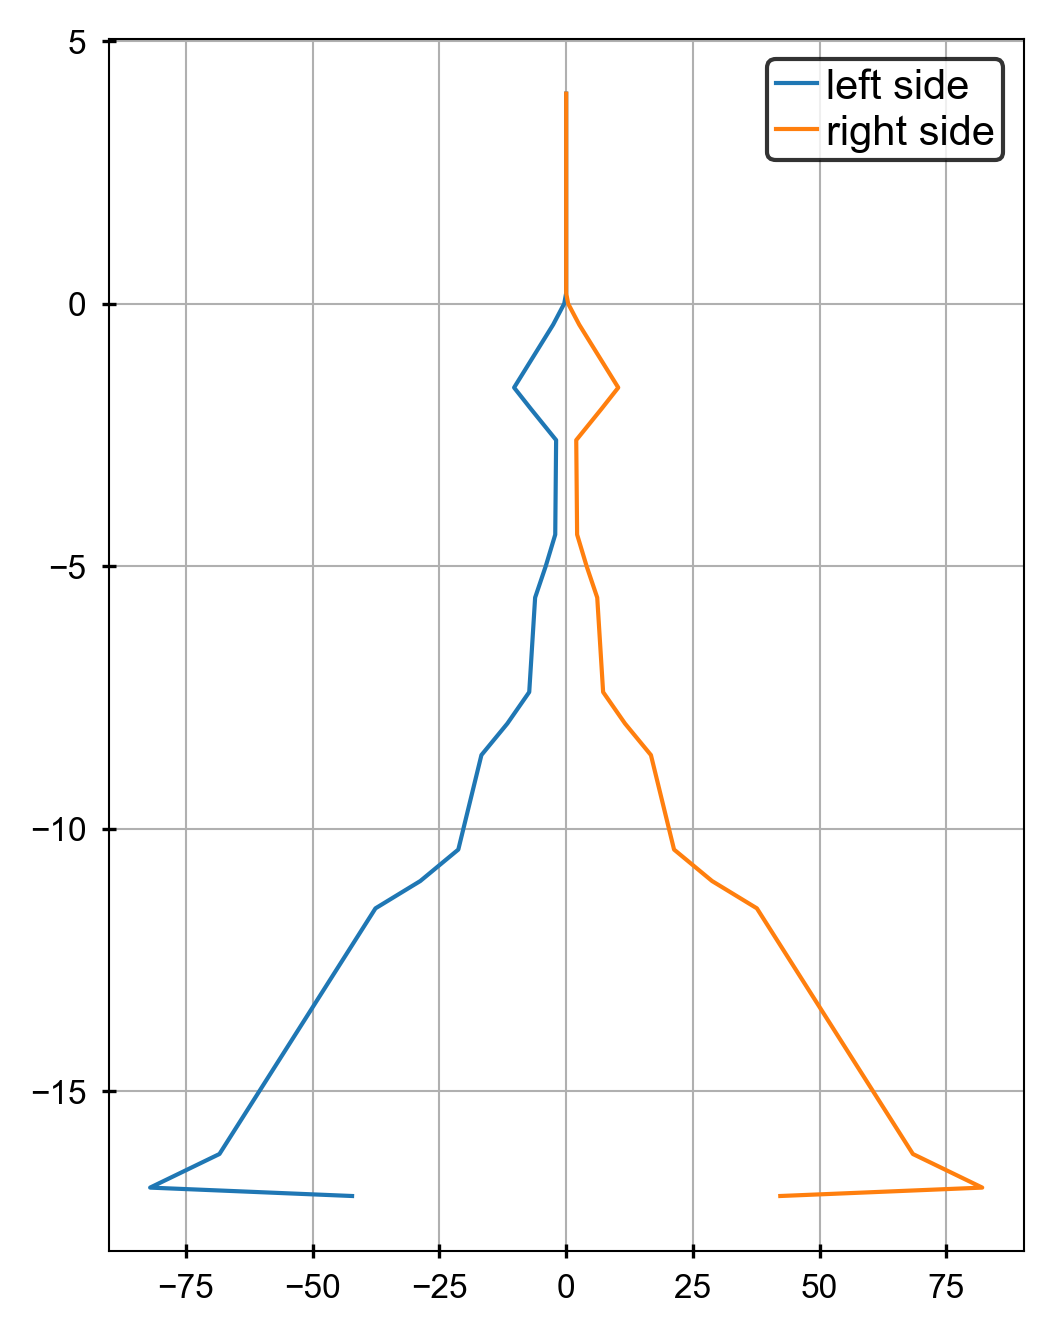

In [42]:
plt.plot(f_ls[::2], xyz, label='left side')
plt.plot(f_rs[::2], xyz, label='right side')
plt.legend()

In [43]:
np.sum(f_rs[::2])

np.float64(1068.7499999999998)